# Importing Required Libraries

In [1]:
#importing the libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder ,StandardScaler
from sklearn.compose import  make_column_transformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load The Dataset

In [3]:
# Loading the raw dataset
data = pd.read_csv('C:\\Users\\Rimi\\Documents\\SpringBoard\\processed_train.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# Checking for duplicates and removing them if any
data.drop_duplicates(inplace=True)

In [5]:
#Check if there are still missing values in the data
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


# Feature Derivation

To create a new feature called Outlet_Age by calculating the age of the store from the year it was established (Outlet_Establishment_Year):

In [25]:
# Creating the 'Outlet_Age' feature based on the current year (2024)
data['Outlet_Age'] = 2024 - data['Outlet_Establishment_Year']

# Check the new feature alongside the establishment year
print(data[['Outlet_Establishment_Year', 'Outlet_Age']].head())

   Outlet_Establishment_Year  Outlet_Age
0                       1999          25
1                       2009          15
2                       1999          25
3                       1998          26
4                       1987          37


# Feature Encoding

Feature encoding was performed on both nominal and ordinal features in the dataset. This converts categorical values into numerical labels, making the data compatible with machine learning models.

In [27]:

# Assuming nominal and ordinal data columns
nominal_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']  # Categorical without order
ordinal_cols = ['Outlet_Size']  # Categorical with order, e.g., Small < Medium < High
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP','Item_Outlet_Sales', 'Outlet_Establishment_Year', 'Outlet_Age']  # Numerical columns

# Display identified nominal and ordinal and numerical columns
print("\nNominal Columns:", nominal_cols)
print("Ordinal Columns:", ordinal_cols)
print("Numerical Columns:", numerical_columns)


Nominal Columns: ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
Ordinal Columns: ['Outlet_Size']
Numerical Columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Outlet_Establishment_Year', 'Outlet_Age']


In [29]:
# Define the mapping for the ordinal column 'Outlet_Size'
Outlet_Size_mapping = ['Small', 'Medium', 'High'] 

In [31]:
#applying Encoding Techniques for Columns
ohe = OneHotEncoder(drop='first', sparse_output=False)  # For nominal columns
ode = OrdinalEncoder(categories=[Outlet_Size_mapping])  # For ordinal column
scaler = StandardScaler()  # For numeric columns

In [33]:
ct = make_column_transformer(
    (ohe, ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']),  # Nominal columns
    (ode, ['Outlet_Size']),  # Ordinal column
    (scaler, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 
              'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Outlet_Age']),  # Numeric columns
    remainder='passthrough'  # Columns not listed will be passed through without changes
)

ct.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Location_Type', 'Outlet_Type']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Small', 'Medium',
                                                             'High']]),
                                 ['Outlet_Size']),
                                ('standardscaler', StandardScaler(),
                                 ['Item_Weight', 'Item_Visibility', 'Item_MRP',
                                  'Outlet_Establishment_Year',
                                  'Item_Outlet_Sales', 'Outlet_Age'])])

In [35]:
data_encoded = ct.fit_transform(data)

data_encoded.columns = [col.replace("onehotencoder__", "")
                             .replace("ordinalencoder__", "")
                             .replace("standardscaler__", "") 
                             for col in data_encoded.columns]

print("Encoded Columns:\n", data_encoded.columns.tolist())

Encoded Columns:
 ['Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Outlet_Size', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Outlet_Age', 'remainder__Item_Identifier', 'remainder__Outlet_Identifier']



# Outlier Detection

* Using Z-score method : The Z-score method for outlier detection is a statistical technique used to identify data points that are significantly different from the mean of a dataset. It is based on the standardization of data, using the Z-score formula to measure how many standard deviations a data point is from the mean.

Here’s how you can implement outlier detection using the z-score method in Python, including handling the continuous columns and visualizing the outliers using boxplots.
  

In [38]:
# Define Continuous columns
continuous_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']


In [40]:
# Z-Score threshold for detecting outliers
z_threshold = 2.5

In [42]:
# Dictionary to hold outliers for each column
outliers_dict = {}

# Loop over each continuous column to calculate z-scores and find outliers
for col in continuous_columns:
    # Calculate the z-score for the column
    data[col + '_zscore'] = np.abs((data[col] - data[col].mean()) / data[col].std())
    
    # Detect outliers where z-score is greater than the threshold
    outliers_dict[col] = data[data[col + '_zscore'] > z_threshold]

    # Print the number of outliers detected
    print(f"{col}: {outliers_dict[col].shape[0]} outliers detected.")


Item_Weight: 0 outliers detected.
Item_Visibility: 146 outliers detected.
Item_MRP: 0 outliers detected.
Item_Outlet_Sales: 197 outliers detected.


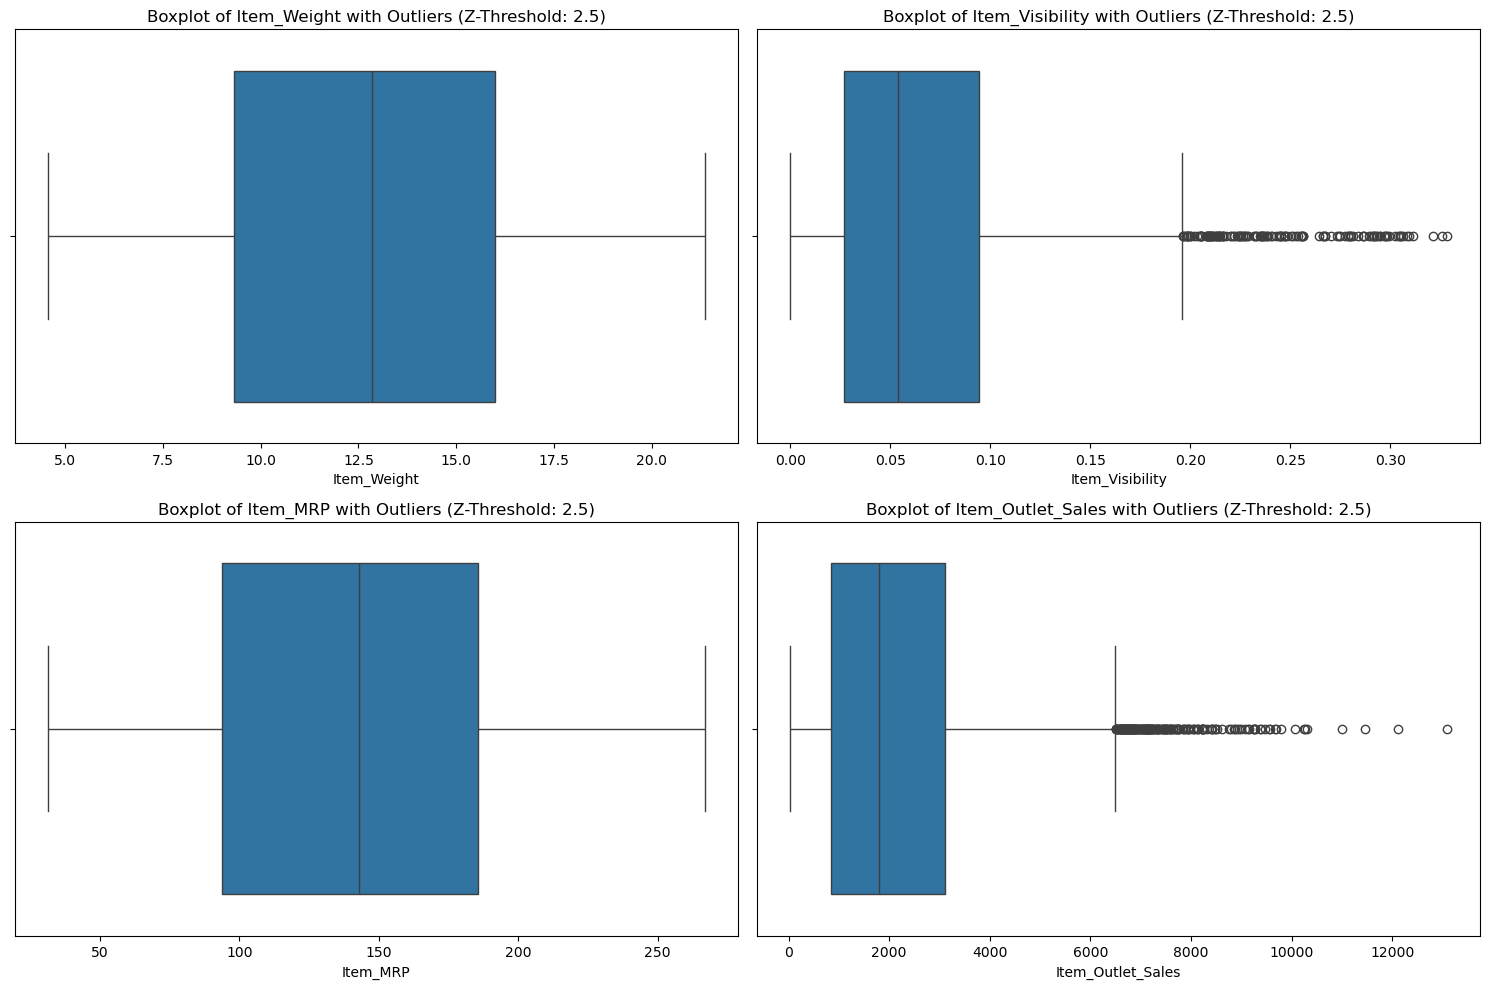

In [44]:
# Create a 2x2 grid of boxplots for the continuous columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(continuous_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col} with Outliers (Z-Threshold: {z_threshold})')

# Adjust the layout
plt.tight_layout()
plt.show()


# Remove Outliers

In [47]:
# Removing rows where Z-score for 'Item_Outlet_Sales' is greater than the threshold
outliers_removed = data[data['Item_Outlet_Sales_zscore'] < z_threshold]

# Print the original and new dataset sizes
print(f"Original dataset size: {data.shape}")
print(f"Dataset size after removing outliers: {outliers_removed.shape}")


Original dataset size: (8523, 17)
Dataset size after removing outliers: (8326, 17)


* Using the IQR Method for Outlier Detection

* The IQR (Interquartile Range) method is another common approach to detect and remove outliers. Here's how you can apply it:

In [269]:
'''# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Checking for outliers in numerical columns
numerical_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
outliers = {}

for col in numerical_cols:
    outliers[col] = detect_outliers_iqr(data, col)
    print(f"Outliers detected in {col}: {len(outliers[col])}")'''


'# Function to detect outliers using IQR\ndef detect_outliers_iqr(data, column):\n    Q1 = data[column].quantile(0.25)\n    Q3 = data[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]\n\n# Checking for outliers in numerical columns\nnumerical_cols = [\'Item_Weight\', \'Item_Visibility\', \'Item_MRP\', \'Item_Outlet_Sales\']\noutliers = {}\n\nfor col in numerical_cols:\n    outliers[col] = detect_outliers_iqr(data, col)\n    print(f"Outliers detected in {col}: {len(outliers[col])}")'

In [271]:
'''# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Item_Outlet_Sales'].quantile(0.25)
Q3 = data['Item_Outlet_Sales'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers using IQR method
outliers_removed_iqr = data[(data['Item_Outlet_Sales'] >= lower_bound) & (data['Item_Outlet_Sales'] <= upper_bound)]

# Print dataset size after removing outliers using IQR
print(f"Dataset size after removing outliers using IQR: {outliers_removed_iqr.shape}")'''

'# Calculate Q1 (25th percentile) and Q3 (75th percentile)\nQ1 = data[\'Item_Outlet_Sales\'].quantile(0.25)\nQ3 = data[\'Item_Outlet_Sales\'].quantile(0.75)\n\n# Calculate IQR\nIQR = Q3 - Q1\n\n# Define bounds for outliers\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# Removing outliers using IQR method\noutliers_removed_iqr = data[(data[\'Item_Outlet_Sales\'] >= lower_bound) & (data[\'Item_Outlet_Sales\'] <= upper_bound)]\n\n# Print dataset size after removing outliers using IQR\nprint(f"Dataset size after removing outliers using IQR: {outliers_removed_iqr.shape}")'


* Assuming outliers_removed is cleaned dataset

In [223]:
# Columns to be standardized
scaled_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

In [225]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize the specified columns and assign the result back to the dataframe correctly
outliers_removed[scaled_columns] = scaler.fit_transform(outliers_removed[scaled_columns])

outliers_removed.head()


C:\Users\Rimi\AppData\Local\Temp\ipykernel_6228\1710239257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_removed[scaled_columns] = scaler.fit_transform(outliers_removed[scaled_columns])


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Weight_zscore,Item_Visibility_zscore,Item_MRP_zscore,Item_Outlet_Sales_zscore
0,FDA15,-0.823778,Low Fat,-0.971109,Dairy,1.800763,OUT049,1999,Medium,Tier 1,Supermarket Type1,1.122235,25,0.828359,0.970675,1.747351,0.910548
1,DRC01,-1.615975,Regular,-0.908784,Soft Drinks,-1.476024,OUT018,2009,Medium,Tier 3,Supermarket Type2,-1.074526,15,1.625269,0.908058,1.488936,1.018381
2,FDN15,1.098121,Low Fat,-0.957359,Meat,0.041710,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.029187,25,1.104972,0.956861,0.010040,0.049235
3,FDX07,1.496564,Regular,-1.280664,Fruits and Vegetables,0.699815,OUT010,1998,Small,Tier 3,Grocery Store,-0.881687,26,1.505785,1.281683,0.660011,0.849053
4,NCD19,-0.910498,Low Fat,-1.280664,Household,-1.385102,OUT013,1987,High,Tier 3,Supermarket Type1,-0.706622,37,0.915595,1.281683,1.399138,0.695332


# Feature Scaling
* Apply Min-Max Scaling

In [228]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply Min-Max Scaling to 'Item_MRP' and 'Item_Visibility' and replace the values in the original DataFrame using .loc[]
data.loc[:, ['Item_MRP', 'Item_Visibility']] = min_max_scaler.fit_transform(data[['Item_MRP', 'Item_Visibility']])

# Check the scaled data
print(data[['Item_MRP', 'Item_Visibility']].head())

   Item_MRP  Item_Visibility
0  0.927507         0.048866
1  0.072068         0.058705
2  0.468288         0.051037
3  0.640093         0.000000
4  0.095805         0.000000


# Target Variable Transformation

We will plot the distribution of the target variable Item_Outlet_Sales before and after applying transformations. The target variable is highly skewed, and we aim to make it more normally distributed.



<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

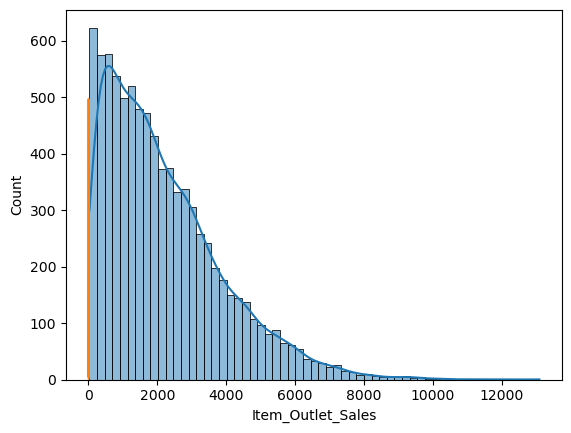

In [231]:

# Investigate the distribution of 'Item_Outlet_Sales'
sns.histplot(data['Item_Outlet_Sales'], kde=True)

# Apply log transformation to address skewness
data['Item_Outlet_Sales_Log'] = np.log1p(data['Item_Outlet_Sales'])

# Check distribution after transformation
sns.histplot(data['Item_Outlet_Sales_Log'], kde=True)

In [233]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Weight_zscore,Item_Visibility_zscore,Item_MRP_zscore,Item_Outlet_Sales_zscore,Item_Outlet_Sales_Log
0,FDA15,9.300,Low Fat,0.048866,Dairy,0.927507,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,25,0.828359,0.970675,1.747351,0.910548,8.225808
1,DRC01,5.920,Regular,0.058705,Soft Drinks,0.072068,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,15,1.625269,0.908058,1.488936,1.018381,6.096776
2,FDN15,17.500,Low Fat,0.051037,Meat,0.468288,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,25,1.104972,0.956861,0.010040,0.049235,7.648868
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,0.640093,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,26,1.505785,1.281683,0.660011,0.849053,6.597664
4,NCD19,8.930,Low Fat,0.000000,Household,0.095805,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,37,0.915595,1.281683,1.399138,0.695332,6.903451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.172914,Snack Foods,0.777729,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,37,1.402464,0.181183,1.180714,0.349894,7.929984
8519,FDS36,8.380,Regular,0.143069,Baking Goods,0.326263,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,22,1.045270,0.371132,0.527270,0.956346,6.310436
8520,NCJ29,10.600,Low Fat,0.107148,Health and Hygiene,0.228492,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,20,0.521856,0.599749,0.897155,0.579066,7.085159
8521,FDN46,7.210,Regular,0.442219,Snack Foods,0.304939,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,15,1.321123,1.532790,0.607941,0.196713,7.521100


In [49]:
data_encoded

,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Age,remainder__Item_Identifier,remainder__Outlet_Identifier
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.828408,-0.970732,1.747454,0.139541,0.910601,-0.139541,FDA15,OUT049
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-1.625364,-0.908111,-1.489023,1.334103,-1.018440,-1.334103,DRC01,OUT018
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.105037,-0.956917,0.010040,0.139541,-0.049238,-0.139541,FDN15,OUT049
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.505873,-1.281758,0.660050,0.020085,-0.849103,-0.020085,FDX07,OUT010
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,-0.915649,-1.281758,-1.399220,-1.293934,-0.695373,1.293934,NCD19,OUT013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,-1.402547,-0.181193,1.180783,-1.293934,0.349915,1.293934,FDF22,OUT013
8519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.045331,-0.371154,-0.527301,0.497909,-0.956402,-0.497909,FDS36,OUT045
8520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.521886,-0.599784,-0.897208,0.736822,-0.579100,-0.736822,NCJ29,OUT035
8521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-1.321200,1.532880,-0.607977,1.334103,-0.196725,-1.334103,FDN46,OUT018
